referring to this medium article:

https://wire.insiderfinance.io/statistical-arbitrage-in-python-how-ken-griffin-built-a-fortune-917758234152

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the basket of assets
tickers = ["AAPL", "MSFT", "GOOGL"]

# Download historical Adjusted Close prices (last 2 years)
data = yf.download(tickers, start="2023-01-01", end="2025-02-26")

# Check the data
print(data.head())

/var/folders/z_/9h44s4jd1_v60ytmp987cz8m0000gn/T/ipykernel_21929/3946870560.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2023-01-01", end="2025-02-26")
[*********************100%***********************]  3 of 3 completed

Price            Close                               High             \
Ticker            AAPL      GOOGL        MSFT        AAPL      GOOGL   
Date                                                                   
2023-01-03  123.470619  88.588699  234.808960  129.226060  90.507194   
2023-01-04  124.744125  87.554909  224.537674  127.014716  90.109587   
2023-01-05  123.421257  85.686104  217.882843  126.136090  87.047939   
2023-01-06  127.962425  86.819313  220.450699  128.623856  87.167233   
2023-01-09  128.485641  87.495255  222.597092  131.703962  89.513159   

Price                          Low                               Open  \
Ticker            MSFT        AAPL      GOOGL        MSFT        AAPL   
Date                                                                    
2023-01-03  240.856088  122.582127  87.992270  232.672365  128.613993   
2023-01-04  228.232587  123.480495  86.749732  221.460205  125.267347   
2023-01-05  223.018497  123.164587  85.387897  217.343793 

In [5]:
data.columns

MultiIndex([( 'Close',  'AAPL'),
            ( 'Close', 'GOOGL'),
            ( 'Close',  'MSFT'),
            (  'High',  'AAPL'),
            (  'High', 'GOOGL'),
            (  'High',  'MSFT'),
            (   'Low',  'AAPL'),
            (   'Low', 'GOOGL'),
            (   'Low',  'MSFT'),
            (  'Open',  'AAPL'),
            (  'Open', 'GOOGL'),
            (  'Open',  'MSFT'),
            ('Volume',  'AAPL'),
            ('Volume', 'GOOGL'),
            ('Volume',  'MSFT')],
           names=['Price', 'Ticker'])

In [6]:
close_data = data['Close']

In [7]:
close_data.min()

Ticker
AAPL     123.421257
GOOGL     85.686104
MSFT     217.882843
dtype: float64

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the basket
tickers = ["KO", "PEP"]

# Fetch historical data (e.g., 2023 for illustration)
data = yf.download(tickers, start="2023-01-01", end="2023-12-31")["Close"]
print(data.head())

data

/var/folders/z_/9h44s4jd1_v60ytmp987cz8m0000gn/T/ipykernel_21929/2075059665.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2023-01-01", end="2023-12-31")["Close"]
[*********************100%***********************]  2 of 2 completed

Ticker             KO         PEP
Date                             
2023-01-03  58.367386  165.692642
2023-01-04  58.339565  165.286240
2023-01-05  57.671982  163.559250
2023-01-06  58.784615  167.253418
2023-01-09  58.052128  165.618729


Ticker,KO,PEP
Date,,
2023-01-03,58.367386,165.692642
2023-01-04,58.339565,165.286240
2023-01-05,57.671982,163.559250
2023-01-06,58.784615,167.253418
2023-01-09,58.052128,165.618729
...,...,...
2023-12-22,55.780437,159.305069
2023-12-26,56.009991,160.426117
2023-12-27,56.153458,160.939148


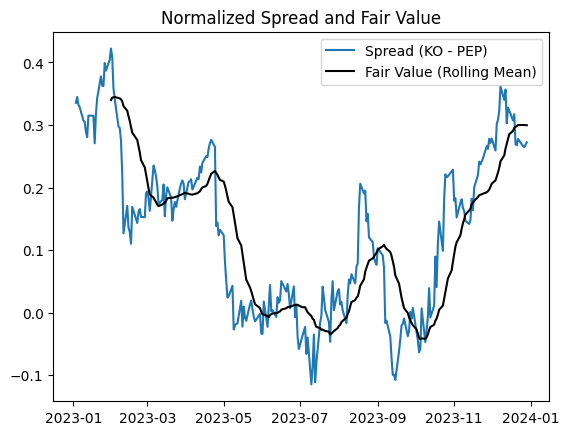

In [9]:
# Normalize prices (scale to 0-1)
normalized_prices = (data - data.min()) / (data.max() - data.min())

# Calculate the spread (difference between normalized prices)
spread = normalized_prices["KO"] - normalized_prices["PEP"]

# Fair value as a rolling mean of the spread (20-day window)
window = 20
fair_value = spread.rolling(window=window).mean()

# Plot
plt.plot(spread, label="Spread (KO - PEP)")
plt.plot(fair_value, label="Fair Value (Rolling Mean)", color="black")
plt.legend()
plt.title("Normalized Spread and Fair Value")
plt.show()

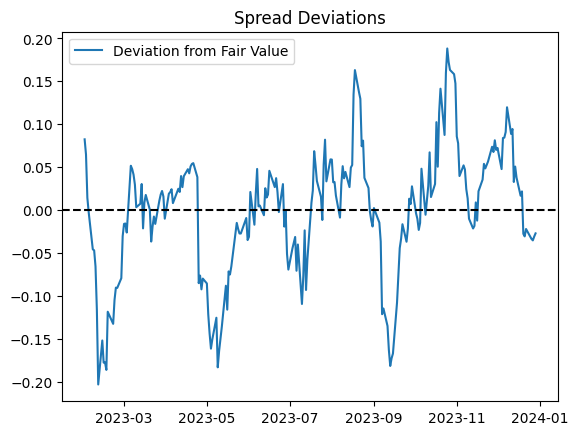

In [11]:
# Calculate deviations
deviations = spread - fair_value

# Plot deviations
plt.plot(deviations, label="Deviation from Fair Value")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.title("Spread Deviations")
plt.show()

In [12]:
# Define thresholds
upper_threshold = 0.1
lower_threshold = -0.1

# Generate signals (1 = long KO/short PEP, -1 = short KO/long PEP, 0 = hold)
signals = pd.DataFrame(index=data.index, columns=["KO", "PEP"])
signals["KO"] = np.where(deviations > upper_threshold, -1,  # Short KO
                         np.where(deviations < lower_threshold, 1, 0))  # Long KO
signals["PEP"] = -signals["KO"]  # Opposite position for PEP

# Preview signals
print(signals.tail())

            KO  PEP
Date               
2023-12-22   0    0
2023-12-26   0    0
2023-12-27   0    0
2023-12-28   0    0
2023-12-29   0    0


<Axes: title={'center': 'Trading Signals'}, xlabel='Date'>

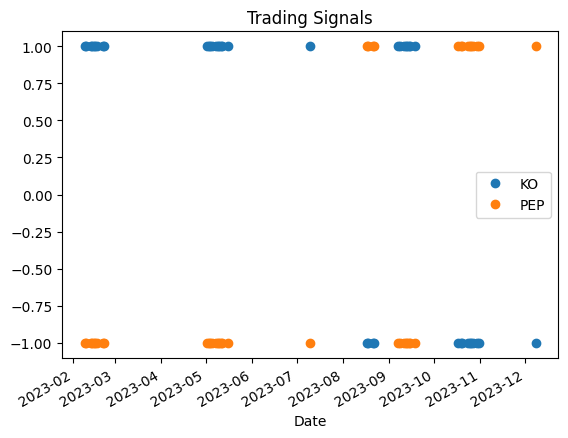

In [14]:
signals[signals["KO"] != 0].plot(style='o', title="Trading Signals")

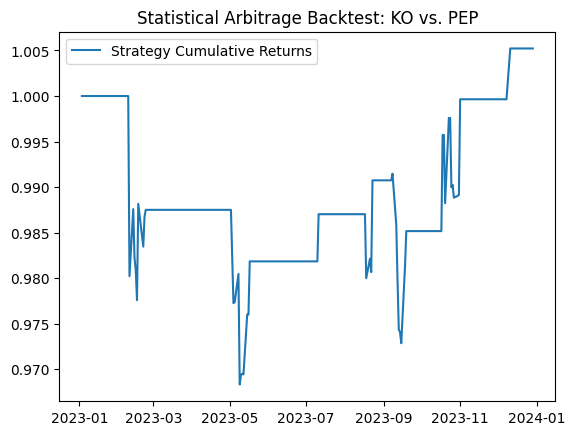

Total Strategy Return: 0.52%


In [15]:
# Daily returns
daily_returns = data.pct_change().dropna()

# Strategy returns (signals applied to KO and PEP returns)
strategy_returns = (signals.shift(1) * daily_returns).sum(axis=1)

# Cumulative returns
cumulative_returns = (1 + strategy_returns).cumprod()

# Plot
plt.plot(cumulative_returns, label="Strategy Cumulative Returns")
plt.title("Statistical Arbitrage Backtest: KO vs. PEP")
plt.legend()
plt.show()

# Total return
total_return = cumulative_returns.iloc[-1] - 1
print(f"Total Strategy Return: {total_return:.2%}")